# Context

We will assess stree levels based on the content of written sentence.

# Importing Libaries

In [9]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.2 kB 435.7 kB/s eta 0:00:01
   ----------- --------------------------- 92.2/300.2 kB 751.6 kB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 1.9 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
import nltk
import re
nltk.download("stopwords")
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword = set(stopwords.words("english"))
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Dataset

In [11]:
data=pd.read_csv('stress.csv')
data

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.800000,1521614353,5,1.806818,...,1.0000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.000000,1527009817,4,9.429737,...,1.1250,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.800000,1535935605,2,7.769821,...,1.0000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.600000,1516429555,0,2.667798,...,1.0000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.800000,1539809005,24,7.554238,...,1.0000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",1713,0,1.000000,1515187044,13,-1.369333,...,1.4000,1.0000,1.0,1.71133,1.45301,2.00304,0.84,16,0.254444,0.552066
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1133,1,1.000000,1539827412,33,9.425478,...,1.0000,1.0000,1.0,1.65003,1.56842,1.81527,0.96,6,8.640664,-0.220370
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,10442,0,1.000000,1539269312,2,11.060675,...,1.1250,1.1250,1.0,1.79768,1.49074,1.92286,1.00,1,9.951524,0.045455
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,1834,0,0.571429,1488938143,4,2.421912,...,1.1111,1.1429,1.0,1.71642,1.57627,1.89972,0.75,7,4.036765,0.159722


In [12]:
data.shape

(2838, 116)

In [13]:
data.isnull().sum()

subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64

In [15]:
data.duplicated().sum()

0

 Very Interesting
- We can see that we have one entry for each post_id
- The dataset dont't have missing values
- The dataset don't have duplicate
- The target that we will use in the label column of this data,contains 0 and 1 values here 1 shows the stress and 0 shows the not stress
- We will use the text column of this data to predict stress or not stress as per written sentences.

In [16]:
def clean(text):
    text = str(text).lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+", "",text)
    text = re.sub("<.*?>+","",text)
    text = re.sub("[%s]" % re.escape(string.punctuation),"",text)
    text = re.sub("\n","",text)
    text = [word for word in text.split(" ") if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(" ")]
    text = " ".join(text)
    return text

In [17]:
data["text"] = data["text"].apply(clean)

In [18]:
data['text'].head()

0    said felt way sugget go rest trigger ahead you...
1    hey rassist sure right place post goe  im curr...
2    mom hit newspap shock would know dont like pla...
3    met new boyfriend amaz kind sweet good student...
4    octob domest violenc awar month domest violenc...
Name: text, dtype: object

 A WordCloud is a visual representation of text data in which words from a corpus are displayed in varying sizes according to their frequency. It is a popular tool for quickly identifying the most significant terms within a body of text and visualizing patterns or themes.

- In a WordCloud, words that appear more frequently in the text are typically displayed larger and bolder, while less common words appear smaller. This allows viewers to grasp the most prominent terms at a glance.

commonly used in various fields¶
- Text Analysis
- Content Marketing
- Social Media Analysis
- Education
- Data Visualization etc

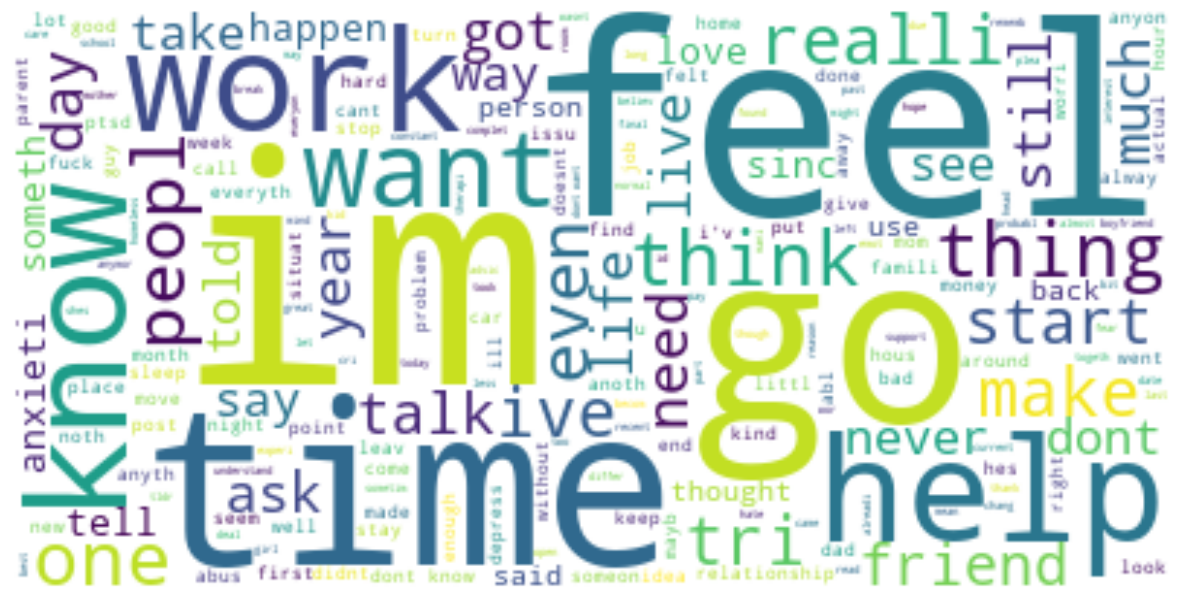

In [19]:
text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
worldcloud = WordCloud(stopwords = stopwords, background_color = "white").generate(text)

plt.figure(figsize = (15,10))
plt.imshow(worldcloud,interpolation = "bilinear")
plt.axis("off")
plt.show()

In [20]:
data['label']=data['label'].map({0:'No Stress',1:'Stress'})

In [21]:
dataset=data[['text','label']]

In [23]:
dataset.head()

,text,label
0,said felt way sugget go rest trigger ahead you...,Stress
1,hey rassist sure right place post goe im curr...,No Stress
2,mom hit newspap shock would know dont like pla...,Stress
3,met new boyfriend amaz kind sweet good student...,Stress
4,octob domest violenc awar month domest violenc...,Stress


 Spliting this dataset into training and test dataset

In [24]:
X= np.array(data['text'])
y=np.array(data['label'])

In [25]:
X

array(['said felt way sugget go rest trigger ahead youir hypocondriac like decid look feel doom hope mayb get suck rabbit hole ludicr conspiraci stupid psychic test new age bs someth could even laugh road end read sens doom indic various health ailment one prone top doom gloomi fn worri heart happen physic 48 hour',
       'hey rassist sure right place post goe  im current student intern sandia nation lab work survey help improv market outreach effort mani school recruit around countri look current undergradgrad stem student your stem student know stem student would great appreci help take pass along short survey thank everyon help take survey enter draw chanc win one three 50 amazon gcs',
       'mom hit newspap shock would know dont like play hit smack strike hit violenc sort person send vibe ask univers yesterday decid take friend go help anoth friend move new place drive friend move strike shoulder address immedi 4th time told thing friend drive near get collis anoth car think high

In [26]:
y

array(['Stress', 'No Stress', 'Stress', ..., 'No Stress', 'No Stress',
       'Stress'], dtype=object)

In [27]:
cv=CountVectorizer()

In [28]:
X=cv.fit_transform(X)

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=42)

 As this task is based on the problem of binary classification

In [30]:
model=BernoulliNB()

In [31]:
model.fit(X_train,y_train)

BernoulliNB()

# Test the performance of our model on some random sentences based on mental health:

In [33]:
user=input('Enter a text:')
data=cv.transform([user]).toarray()
output=model.predict(data)
print(user)
print(output)
    

Enter a sentence:sometime i feel like i need some help
sometime i feel like i need some help
['Stress']


In [34]:
user=input('Enter a sentence:')
data=cv.transform([user]).toarray()
output=model.predict(data)
print(user)
print(output)

Enter a sentence:people need some rest
people need some rest
['No Stress']
